# Identifying Differentially Expressed Genes as part of progeny Pathways using scvi bayes factors
- Created by: Christian Eger
- Creation date: October 14, 2024
- environment: scvi_cuda-env

## Import modules

In [48]:
import scvi
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import anndata as ad
from pathlib import Path
import decoupler as dc
from scipy import sparse
from itertools import chain
import anndata as ad
import math

## Helper Functions

In [59]:
def return_highest_weight_pathway(
        genes: pd.Index,
        progeny_df: pd.DataFrame 
):
    sorted_progeny_df = progeny_df.sort_values(["weight", "target"], ascending=[False, True])
    highest_weight_sources = sorted_progeny_df.drop_duplicates(subset="target", keep="first").set_index("target")["source"]
    return genes.map(lambda gene: highest_weight_sources.get(gene, pd.NA))

def annotate_var_pathways(adata, progeny_df):
    annotated_adata = adata.copy()
    annotated_adata.var = annotated_adata.var.assign(source=lambda x: return_highest_weight_pathway(x.index, progeny_df))
    return annotated_adata

def plot_pathway_degs(adata: ad.AnnData, deg_df: pd.DataFrame, pathways: set[str], comparison: str, save: Path=False):
    pathway_genes_dict = {pathway: set(adata.var[adata.var["source"] == pathway].index) for pathway in pathways}
    pathway_deg_dict = {pathway: deg_df.loc[list(genes)] for pathway, genes in pathway_genes_dict.items()}
    n_pathways = len(pathways)
    n_cols = min(3, n_pathways)  # Max 3 columns
    n_rows = math.ceil(n_pathways / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
    fig.suptitle(f"Top 5 DEGs by Bayes Factor for Each Pathway - {comparison}", fontsize=16)
    axes = axes.flatten() if n_pathways > 1 else [axes]
    
    for i, (pathway, deg) in enumerate(pathway_deg_dict.items()):
        ax = axes[i]
        top_5_deg = deg.sort_values(by="bayes_factor", ascending=False).head(5)
        sns.barplot(x=top_5_deg.index, y="bayes_factor", data=top_5_deg, ax=ax)
        ax.set_title(pathway)
        ax.axhline(3.2, color="r", linestyle="--")
        ax.set_xlabel("Genes")
        ax.set_ylabel("Bayes Factor")
        ax.tick_params(axis='x', rotation=45)
        for j, v in enumerate(top_5_deg["bayes_factor"]):
            ax.text(j, v, f"{v:.2f}", ha='center', va='bottom')
    
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    if save:
        save.mkdir(exist_ok=True)
        plt.savefig(save / f"bayes_factor_DEGs_{comparison}.svg") 
    plt.show()

## Folder Structure

In [55]:
global_repo_data = Path.cwd() / ".." / ".." / ".data"
local_folder_data = Path.cwd() / ".data"
figures_dir = local_folder_data / "figures"

## Data Loading

In [5]:
net = dc.get_progeny(organism='human')
net

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
1395,p53,CCDC150,-3.174527,7.396252e-13
1396,p53,LCE1A,6.154823,8.475458e-13
1397,p53,TREM2,4.101937,9.739648e-13
1398,p53,GDF9,3.355741,1.087433e-12


In [4]:
adata = sc.read_h5ad(global_repo_data / "Marburg_cell_states_locked_ctl240709.raw.h5ad")
adata = annotate_var_pathways(adata, net)
adata

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'viral_counts', 'infected_status', 'seed_labels', 'batch-scANVI'
    var: 'mt', 'ribo'
    uns: 'cell_compartment_colors', 'cell_states_colors', 'disease_colors', 'group_colors', 'infection_colors'
    obsm: 'X_scANVI', 'X_umap'

## scvi Run

In [7]:
scvi.model.SCVI.setup_anndata(
    adata,
    batch_key="batch"
)

/home/ceger/miniforge3/envs/scvi_cuda-env/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


In [8]:
vae = SCVI(adata)
vae.train()

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ceger/miniforge3/envs/scvi_cuda-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader'

Epoch 82/82: 100%|██████████| 82/82 [05:26<00:00,  3.88s/it, v_num=1, train_loss_step=1.71e+4, train_loss_epoch=1.6e+4] 

`Trainer.fit` stopped: `max_epochs=82` reached.


Epoch 82/82: 100%|██████████| 82/82 [05:26<00:00,  3.98s/it, v_num=1, train_loss_step=1.71e+4, train_loss_epoch=1.6e+4]


In [9]:
comparisons = {
    "infection": {("CTRL", "IAV")},
    "disease": {("healthy", "COPD")},
    "group": {("healthy_ctrl", "healthy_iav"),
              ("copd_ctrl", "copd_iav"),
              ("healthy_ctrl", "copd_ctrl"),
              ("healthy_iav", "copd_iav")}
}
comparison_iterator = chain.from_iterable(((groupby, group1, group2) for group1, group2 in value_set) for groupby, value_set in comparisons.items())
deg_dict = {f"{group1}_{group2}": vae.differential_expression(groupby=groupby, group1=group1, group2=group2, mode="change") for groupby, group1, group2 in comparison_iterator}

DE...: 100%|██████████| 1/1 [00:08<00:00,  8.36s/it]


## Results

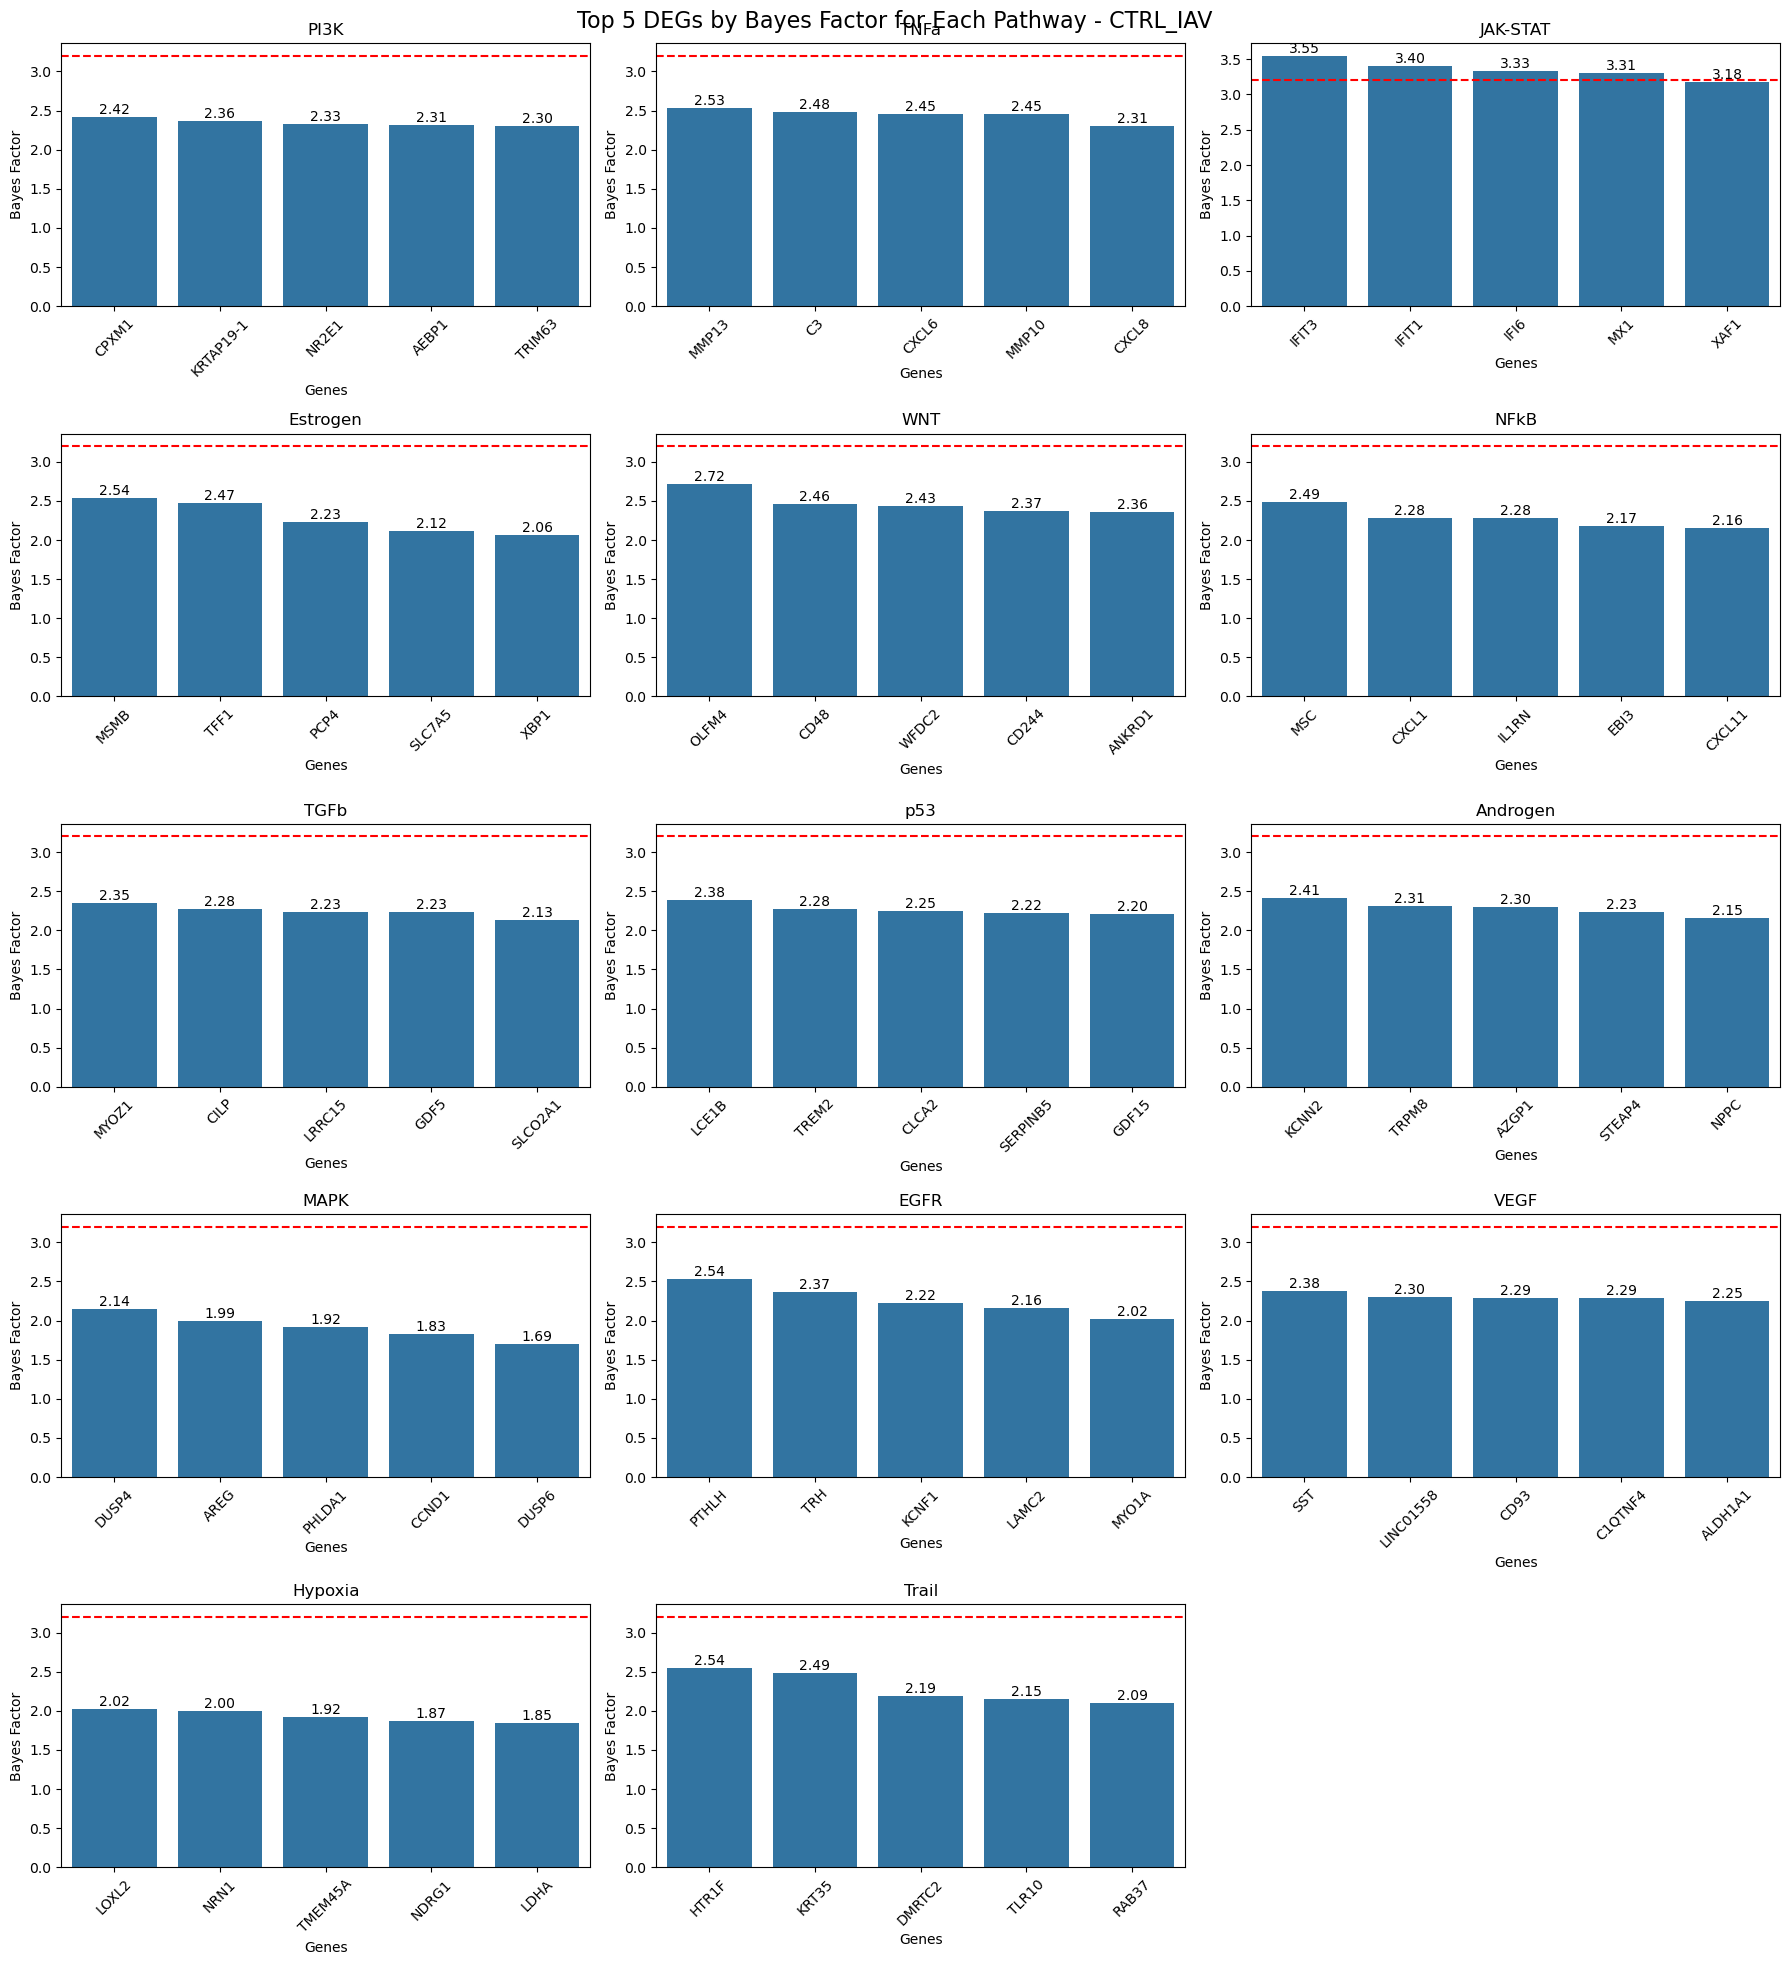

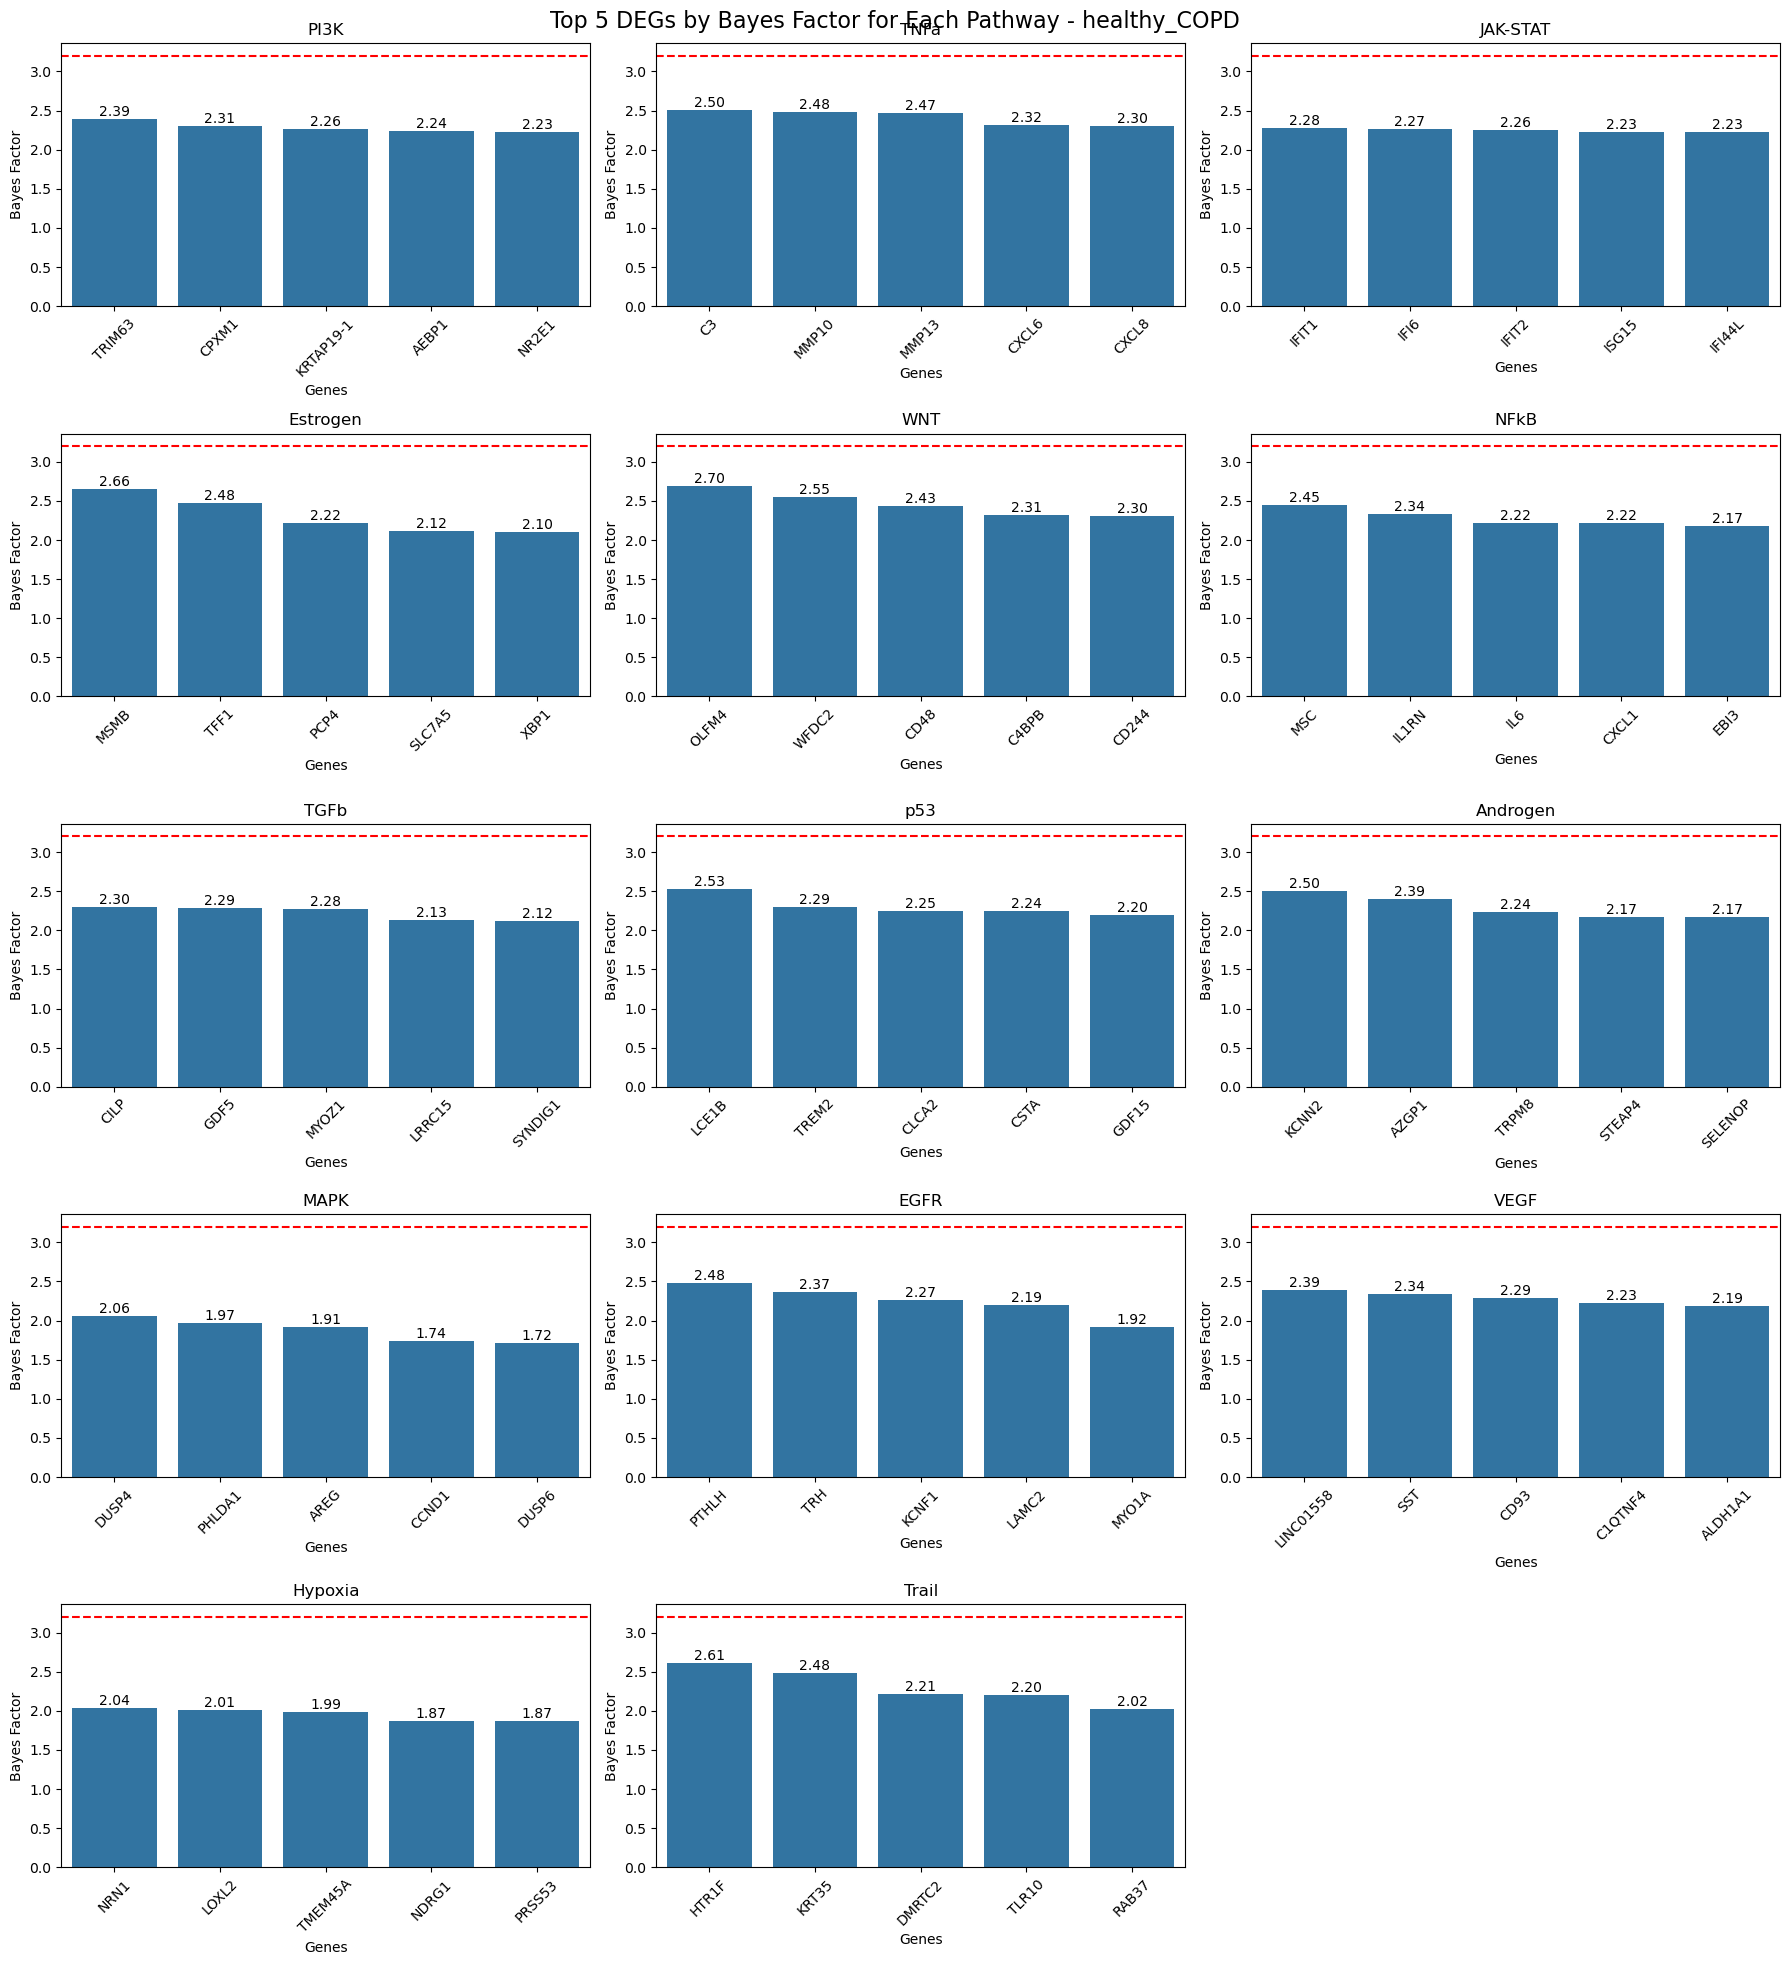

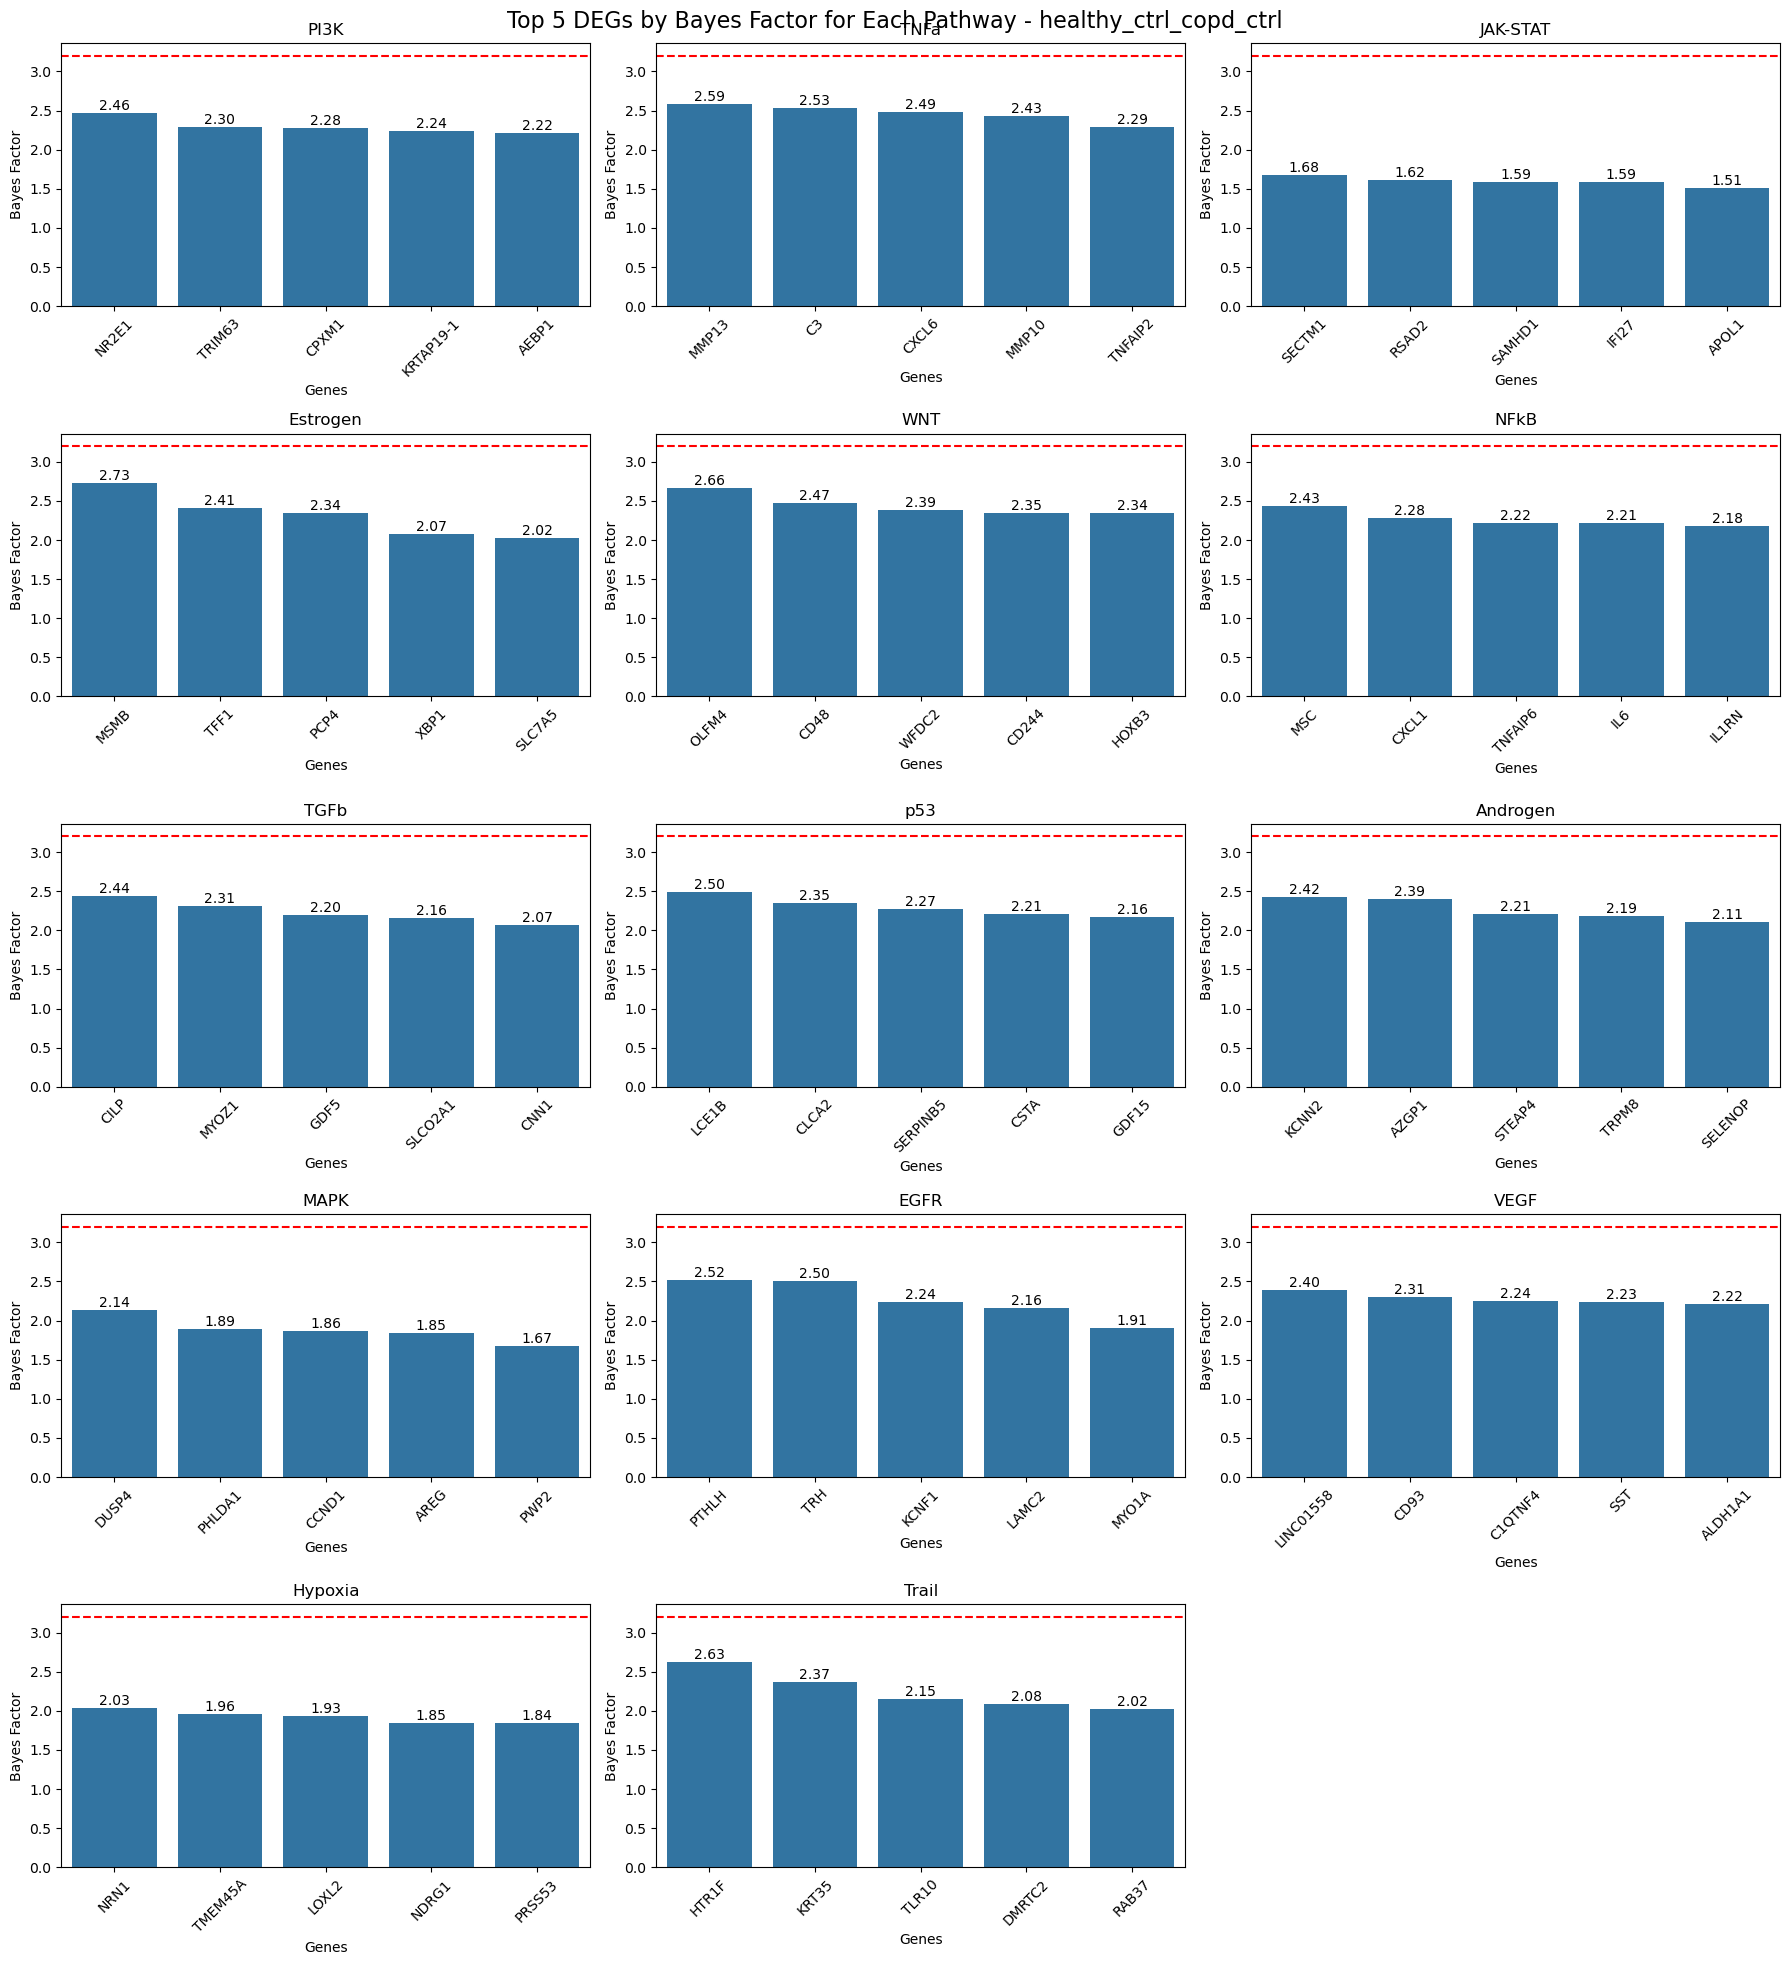

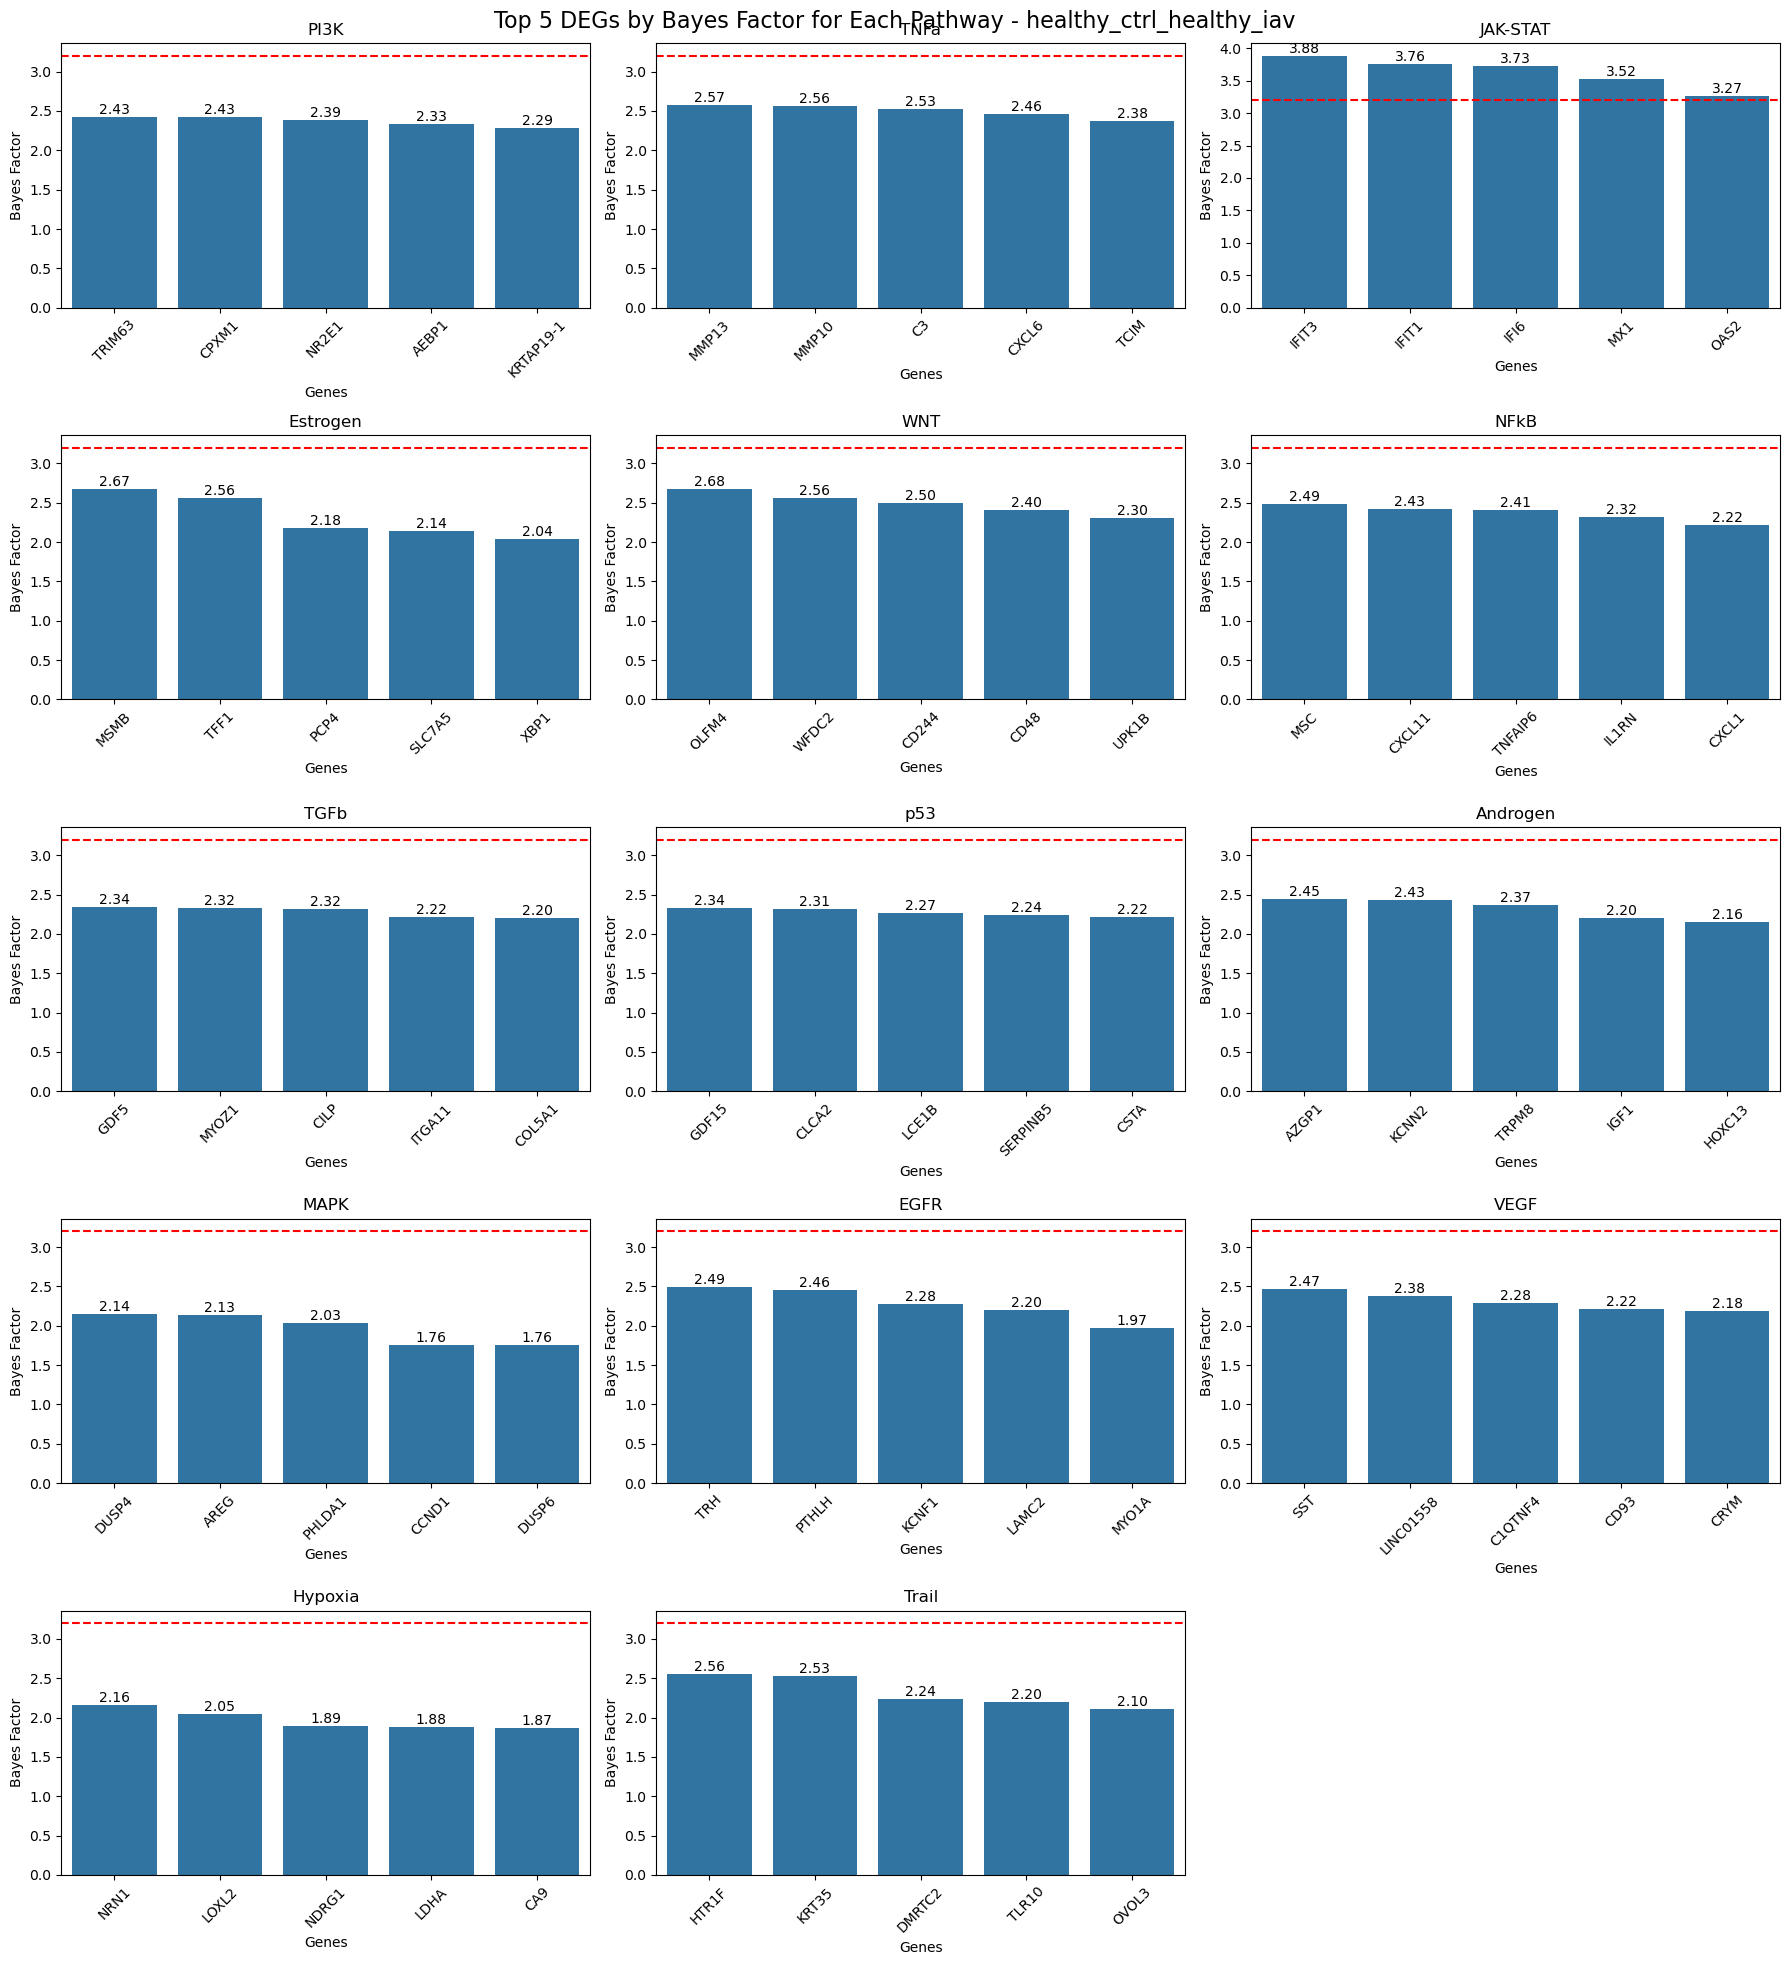

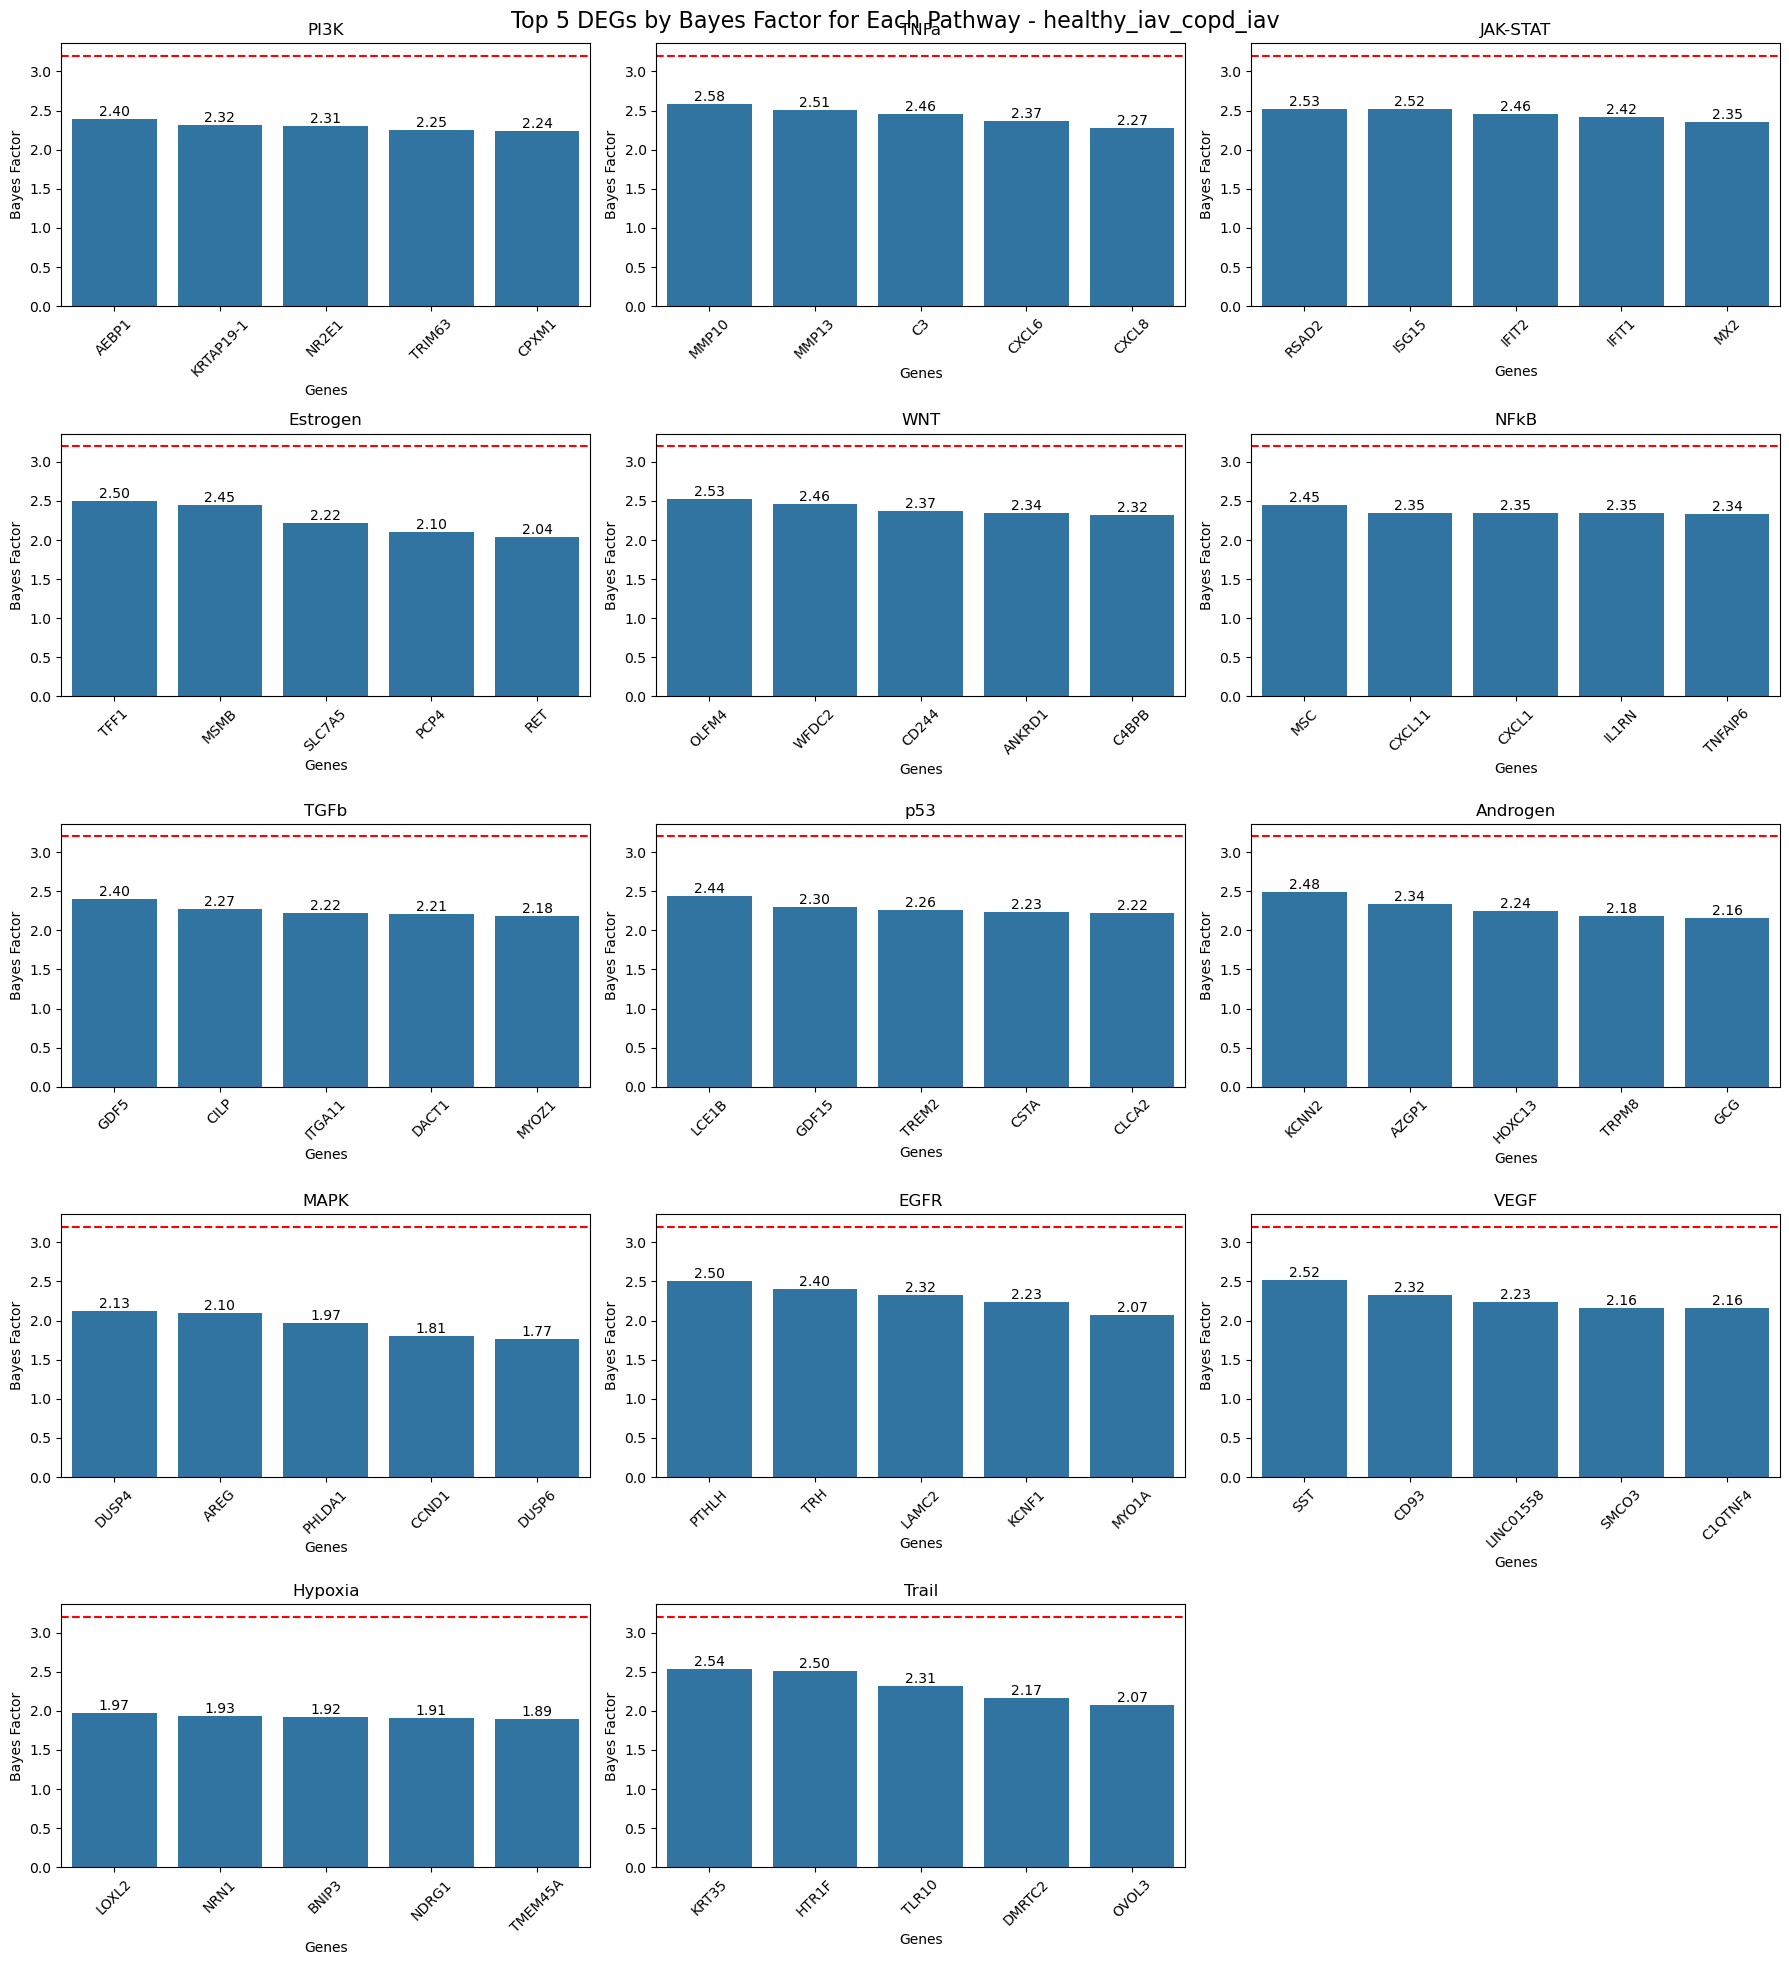

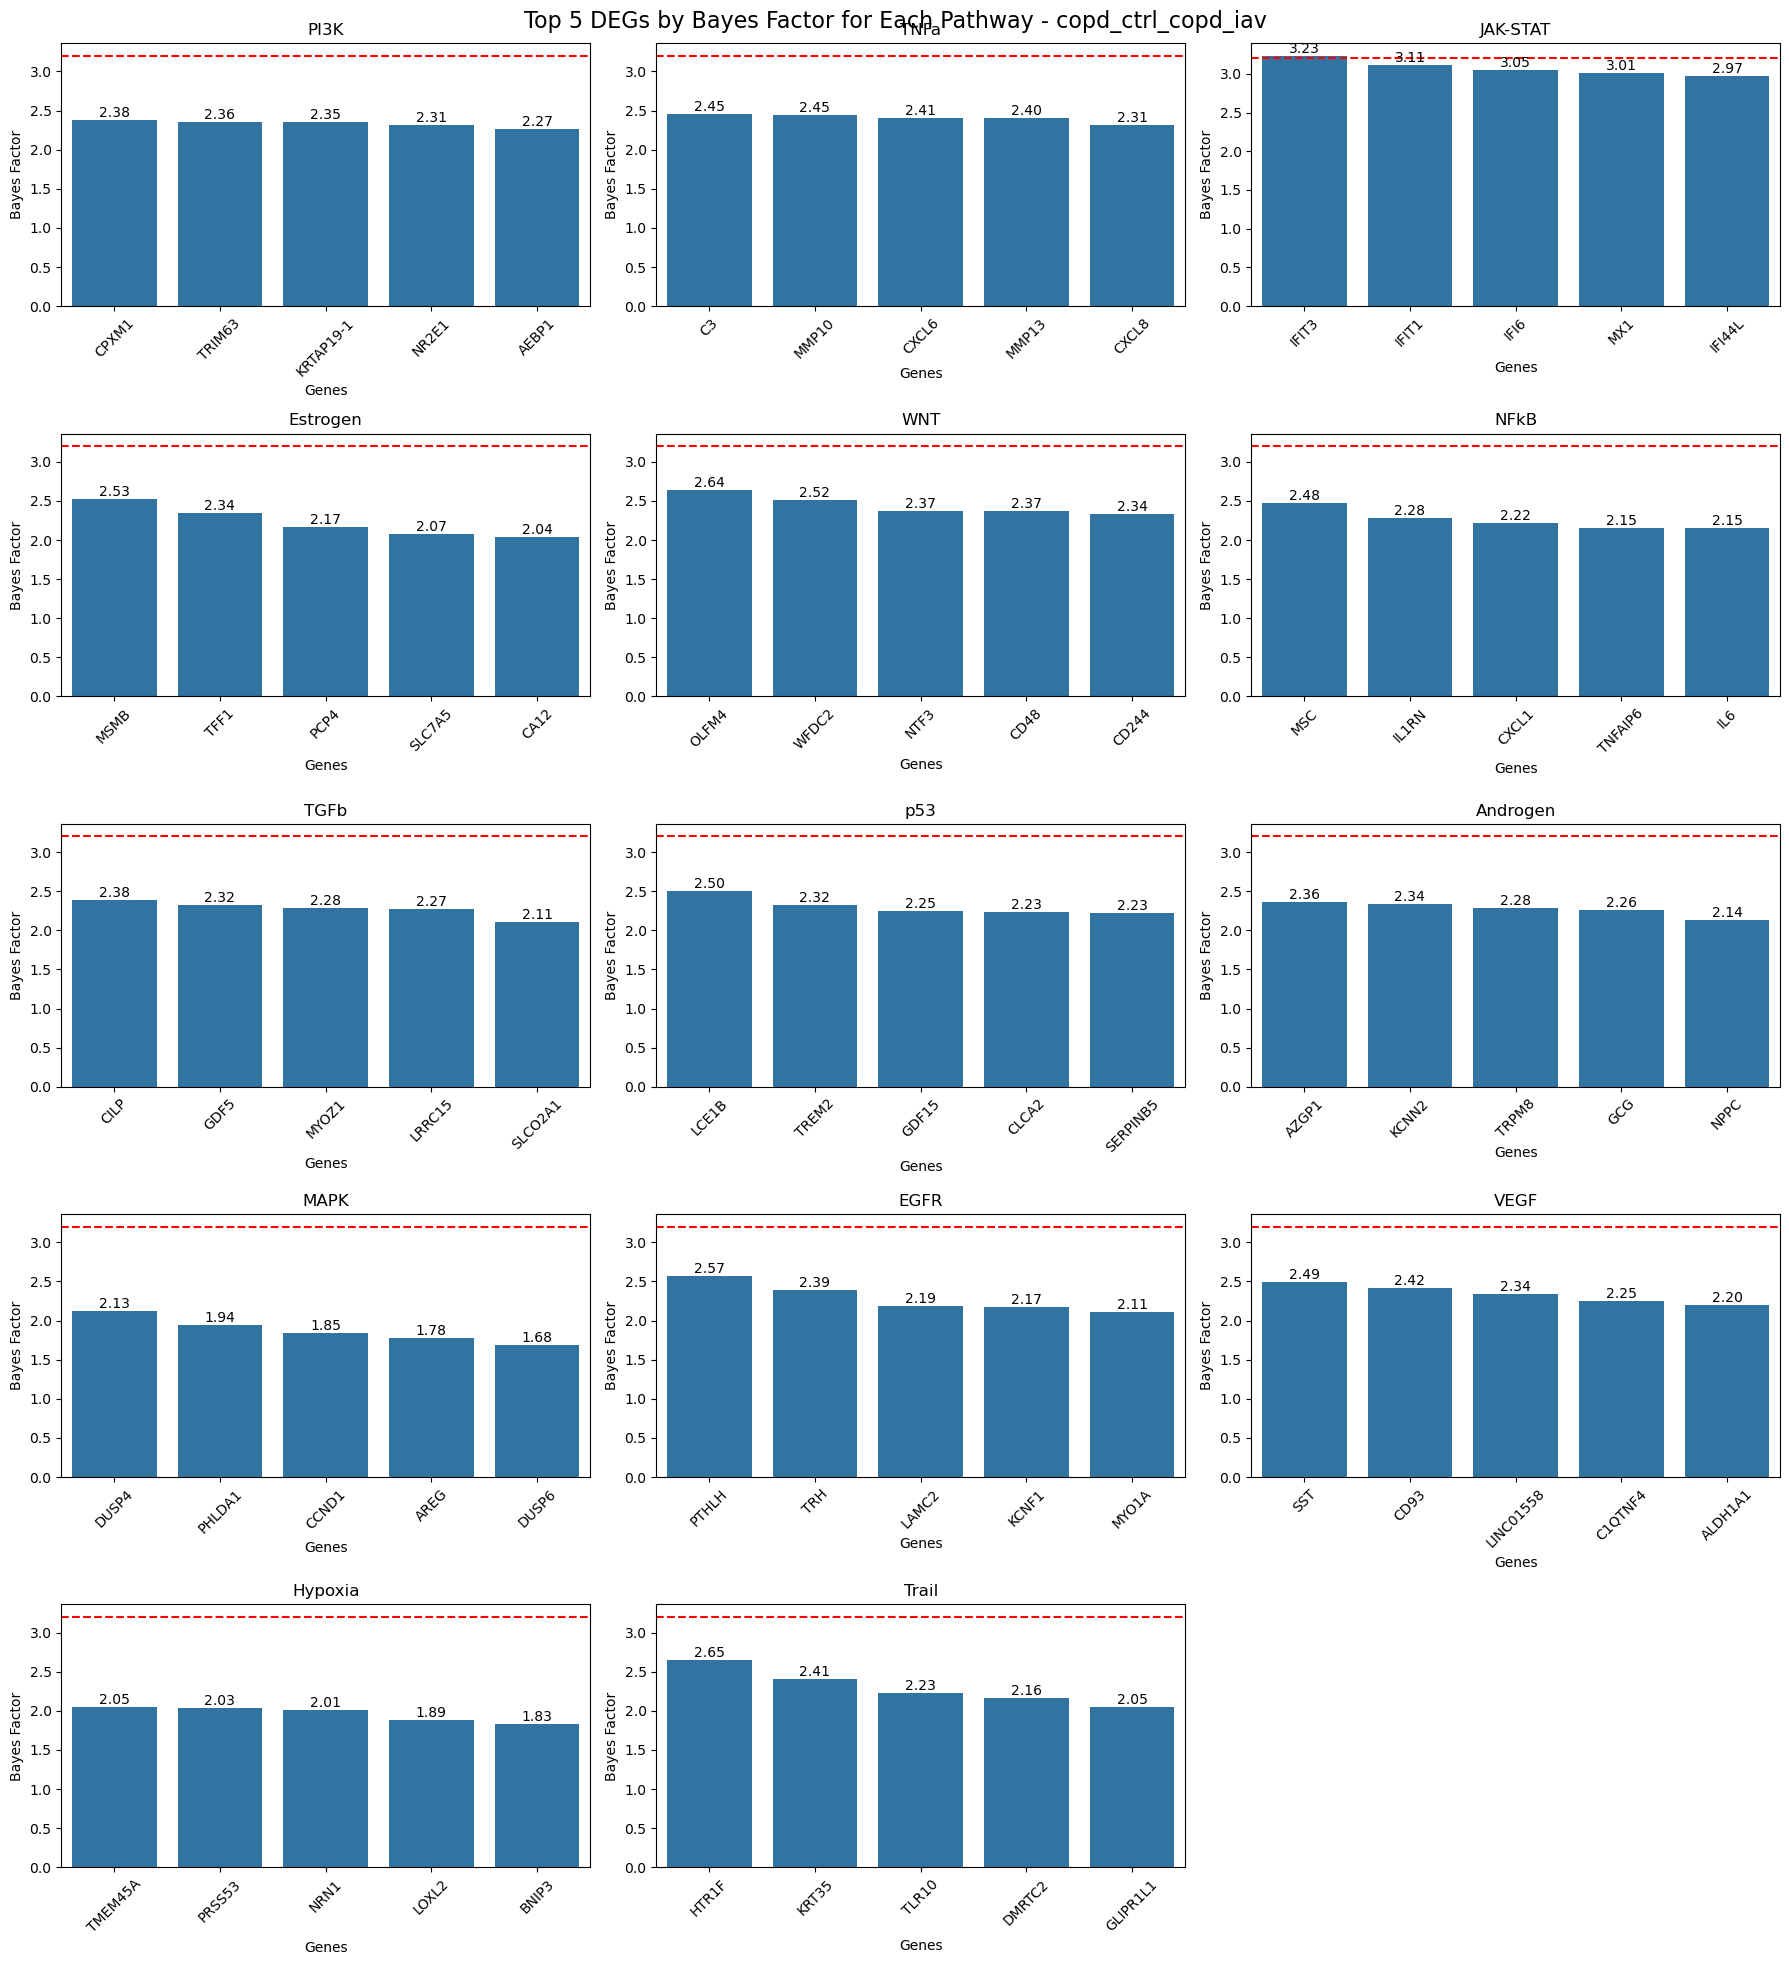

In [60]:
pathways = set(net["source"])
for pathway, deg in deg_dict.items():
    plot_pathway_degs(adata, deg, pathways, pathway, save=figures_dir / "bayes_factor_DEGs")

In [71]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

/home/ceger/miniforge3/envs/scvi_cuda-env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/ceger/miniforge3/envs/scvi_cuda-env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


/home/ceger/miniforge3/envs/scvi_cuda-env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/ceger/miniforge3/envs/scvi_cuda-env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


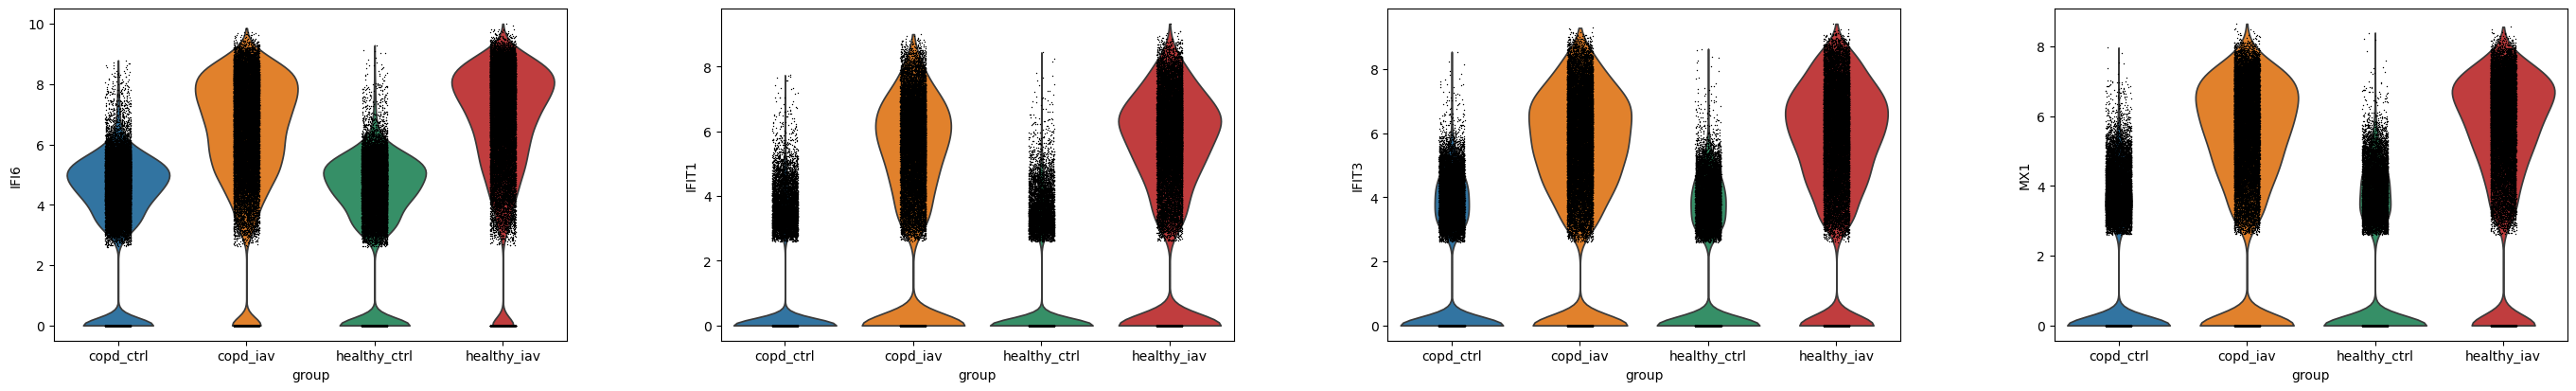

In [86]:
genes_of_interest = {"IFIT3", "IFIT1", "IFI6", "MX1"}
sc.pl.violin(adata, genes_of_interest, groupby="group", save=figures_dir / "expression_violin_group.svg")

/home/ceger/miniforge3/envs/scvi_cuda-env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/ceger/miniforge3/envs/scvi_cuda-env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/ceger/miniforge3/envs/scvi_cuda-env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/ceger/miniforge3/envs/scvi_cuda-env/lib/python3.10/site-packages

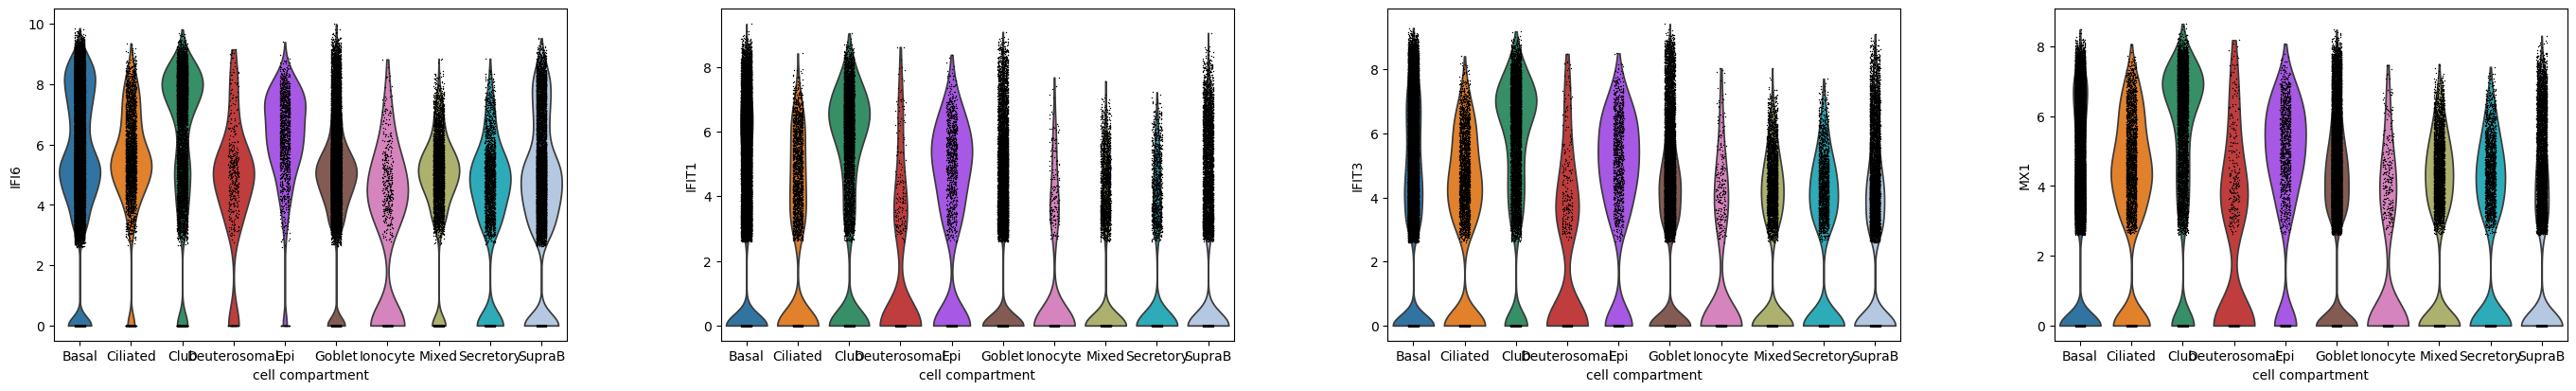

In [87]:
sc.pl.violin(adata, genes_of_interest, groupby="cell_compartment", save=figures_dir / "expression_violin_compartment.svg")